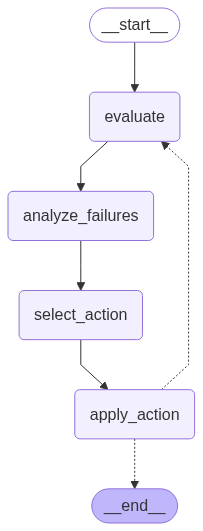

In [3]:
from typing import TypedDict, List, Dict, Any, Literal
import json
import random
from langgraph.graph import StateGraph, END
from langchain_core.prompts import PromptTemplate
from langchain_core.output_parsers import StrOutputParser
from langchain_openai import ChatOpenAI

# Configuration
MAX_ITERATIONS = 10
TARGET_SCORE = 0.9

# State definition
class PromptEngineerState(TypedDict):
    current_prompt: str
    evaluation_dataset: List[Dict[str, Any]]
    performance_metrics: Dict[str, float]
    failure_analysis: List[Dict[str, Any]]
    improvement_actions: List[str]
    iteration_count: int
    best_prompt: str
    best_score: float
    search_history: List[Dict[str, Any]]
    selected_action: str

# Available improvement actions
IMPROVEMENT_ACTIONS = [
    "Add examples",
    "Request step-by-step reasoning", 
    "Be more specific",
    "Add context",
    "Break into sub-tasks",
    "Define the role",
    "Add constraints",
    "Ask for alternatives",
    "Include negative examples",
    "Add verification steps",
    "Specify thinking style",
    "Include edge cases",
    "Add quality criteria",
    "Request explanations",
    "Use iterative refinement"
]

# Initialize LLM (you would replace this with your actual LLM)
# llm = ChatOpenAI(model="gpt-4", temperature=0.3)

def evaluate_prompt_node(state: PromptEngineerState) -> PromptEngineerState:
    """Execute current prompt on dataset and calculate metrics"""
    print(f"🔍 Evaluating prompt (iteration {state['iteration_count']})")
    
    # Simulate evaluation - in real implementation, you'd run the prompt on each Q&A pair
    # and calculate actual metrics like recall, precision, F1, etc.
    
    # Mock performance metrics
    accuracy = random.uniform(0.4, 0.95)
    recall = random.uniform(0.3, 0.9)
    precision = random.uniform(0.4, 0.9)
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    false_positive_rate = random.uniform(0.05, 0.3)
    
    metrics = {
        "accuracy": accuracy,
        "recall": recall,
        "precision": precision,
        "f1_score": f1_score,
        "false_positive_rate": false_positive_rate
    }
    
    # Update best score if improved
    new_best_prompt = state["best_prompt"]
    new_best_score = state["best_score"]
    
    if f1_score > state["best_score"]:
        new_best_prompt = state["current_prompt"]
        new_best_score = f1_score
        print(f"🎉 New best score: {f1_score:.3f}")
    
    return {
        **state,
        "performance_metrics": metrics,
        "best_prompt": new_best_prompt,
        "best_score": new_best_score
    }

def analyze_failures_node(state: PromptEngineerState) -> PromptEngineerState:
    """Analyze wrong answers vs correct answers + explanations"""
    print("📊 Analyzing failure patterns")
    
    # Mock failure analysis - in real implementation, you'd compare generated vs ground truth
    failure_types = [
        "Missing key information in response",
        "Incorrect reasoning chain",
        "Misunderstanding question context",
        "Format not matching expected output",
        "Overconfident in uncertain cases"
    ]
    
    # Generate mock failure analysis
    failures = []
    for i in range(random.randint(2, 5)):
        failures.append({
            "question_id": f"q_{i}",
            "failure_type": random.choice(failure_types),
            "expected": f"Expected answer {i}",
            "actual": f"Generated answer {i}",
            "explanation": f"Ground truth explanation {i}"
        })
    
    return {
        **state,
        "failure_analysis": failures
    }

def select_action_node(state: PromptEngineerState) -> PromptEngineerState:
    """Use meta-prompt to choose improvement action"""
    print("🤖 Selecting improvement action via meta-prompt")
    
    # Meta-prompt template for action selection
    meta_prompt_template = """
    You are an expert prompt engineer. Analyze the current prompt performance and select the best improvement action.
    
    Current Prompt: {current_prompt}
    
    Performance Metrics:
    - Accuracy: {accuracy:.3f}
    - Recall: {recall:.3f}
    - Precision: {precision:.3f}
    - F1 Score: {f1_score:.3f}
    - False Positive Rate: {false_positive_rate:.3f}
    
    Failure Analysis:
    {failure_analysis}
    
    Available Actions:
    {available_actions}
    
    Based on the performance metrics and failure patterns, select the single most impactful action to improve this prompt.
    Respond with just the action name from the available actions list.
    """
    
    # Format failure analysis for prompt
    failure_text = "\n".join([f"- {f['failure_type']}: {f['explanation']}" for f in state["failure_analysis"]])
    actions_text = "\n".join([f"- {action}" for action in IMPROVEMENT_ACTIONS])
    
    # In real implementation, you'd use the LLM here
    # For demo, we'll simulate action selection with some logic
    metrics = state["performance_metrics"]
    
    # Simple heuristic for action selection
    if metrics["recall"] < 0.6:
        selected_action = "Add examples"
    elif metrics["precision"] < 0.6:
        selected_action = "Be more specific"
    elif metrics["f1_score"] < 0.7:
        selected_action = "Request step-by-step reasoning"
    else:
        selected_action = random.choice(IMPROVEMENT_ACTIONS)
    
    print(f"🎯 Selected action: {selected_action}")
    
    return {
        **state,
        "selected_action": selected_action
    }

def apply_action_node(state: PromptEngineerState) -> PromptEngineerState:
    """Apply selected action to modify prompt"""
    print(f"⚡ Applying action: {state['selected_action']}")
    
    # Mock prompt modification - in real implementation, you'd have specific
    # logic for each action type to modify the prompt
    action = state["selected_action"]
    current_prompt = state["current_prompt"]
    
    # Simple prompt modifications based on action
    if action == "Add examples":
        new_prompt = current_prompt + "\n\nExample: [Add specific example here]"
    elif action == "Request step-by-step reasoning":
        new_prompt = current_prompt + "\n\nPlease think through this step-by-step and show your reasoning."
    elif action == "Be more specific":
        new_prompt = current_prompt + "\n\nBe precise and detailed in your response."
    elif action == "Add context":
        new_prompt = current_prompt + "\n\nConsider the relevant context and background information."
    else:
        # Generic modification
        new_prompt = current_prompt + f"\n\n[Applied: {action}]"
    
    # Update search history
    new_history = state["search_history"] + [{
        "iteration": state["iteration_count"],
        "action": action,
        "prompt": new_prompt,
        "metrics": state["performance_metrics"]
    }]
    
    return {
        **state,
        "current_prompt": new_prompt,
        "iteration_count": state["iteration_count"] + 1,
        "search_history": new_history
    }

# Conditional edge function
def should_continue(state: PromptEngineerState) -> Literal["evaluate", "__end__"]:
    """Determine whether to continue or stop the optimization"""
    if state["iteration_count"] >= MAX_ITERATIONS:
        print(f"🛑 Max iterations ({MAX_ITERATIONS}) reached")
        return "__end__"
    
    if state["performance_metrics"]["f1_score"] >= TARGET_SCORE:
        print(f"🎯 Target score ({TARGET_SCORE}) achieved!")
        return "__end__"
    
    return "evaluate"

# Build the workflow
workflow = StateGraph(PromptEngineerState)

# Add nodes
workflow.add_node("evaluate", evaluate_prompt_node)
workflow.add_node("analyze_failures", analyze_failures_node)
workflow.add_node("select_action", select_action_node)
workflow.add_node("apply_action", apply_action_node)

# Define edges
workflow.add_edge("evaluate", "analyze_failures")
workflow.add_edge("analyze_failures", "select_action")
workflow.add_edge("select_action", "apply_action")

# Conditional edge for stopping criteria
workflow.add_conditional_edges("apply_action", should_continue)

# Set entry point
workflow.set_entry_point("evaluate")

# Compile the workflow
app = workflow.compile()

# Visualize the graph (this is the LangGraph way)
try:
    from IPython.display import Image, display
    display(Image(app.get_graph().draw_mermaid_png()))
except ImportError:
    print("To visualize the graph, install: pip install grandalf")
    print("Or use: app.get_graph().print_ascii()")
    # Fallback to ASCII representation
    print("\nWorkflow Graph (ASCII):")
    app.get_graph().print_ascii()



In [ ]:
# Example usage
def run_example():
    """Run an example of the workflow"""
    
    # Initialize state
    initial_state = {
        "current_prompt": "Answer the following question accurately and concisely:",
        "evaluation_dataset": [
            {"question": "What is the capital of France?", "answer": "Paris", "explanation": "Paris is the capital and largest city of France."},
            {"question": "What is 2+2?", "answer": "4", "explanation": "Basic arithmetic: 2+2=4"},
        ],
        "performance_metrics": {},
        "failure_analysis": [],
        "improvement_actions": IMPROVEMENT_ACTIONS,
        "iteration_count": 0,
        "best_prompt": "",
        "best_score": 0.0,
        "search_history": [],
        "selected_action": ""
    }
    
    print("🚀 Starting Prompt Engineering Workflow")
    print("=" * 50)
    
    # Run the workflow
    result = app.invoke(initial_state)
    
    print("\n" + "=" * 50)
    print("✅ Workflow completed!")
    print(f"Final F1 Score: {result['performance_metrics']['f1_score']:.3f}")
    print(f"Total iterations: {result['iteration_count']}")
    print(f"Best prompt: {result['best_prompt'][:100]}...")
    
    return result

# To run the example, uncomment the line below:
# result = run_example()